In [9]:
import os
import gc

import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt, seaborn as sn

from metaspace import SMInstance

import gensim
from gensim import similarities
from gensim.similarities import Similarity
from gensim import models

from pixel_dataframes import create_pixel_df, filter_ions


METAHOST = 'https://metaspace2020.eu'
MOLDBNAME = 'HMDB-v4'
DSID = "2016-09-22_11h16m17s"

# Temporary directory for output
OUTPUT_PATH = 'output'

def filter_ions(images, ann_ions):
    img_ions =[] 
    for image in images:
        s = str(image)
        img_ions.append(s[s.find("(")+1:s.find(")")])
    
    #if len(ann_ions) != len(img_ions):
    diff = len(img_ions)-len(ann_ions)
    print(f'images contain {diff} more ions \n')
    drop_list = []
    for idx, ion in enumerate(img_ions):
        if ion + ann_ions[0][-1] not in ann_ions:
            drop_list.append(idx)
    dropped = [img_ions[i] for i in drop_list]
    img_ions = [img_ions[i] for i in range(len(img_ions)) if i not in drop_list]
    images = [images[i] for i in range(len(images)) if i not in drop_list]

    for i, ion in enumerate(ann_ions): # assert the same image order
        name_len = len(ion[:-1])
        assert ion[:name_len] == img_ions[i][:name_len], f"{ion[:-1]} != {img_ions[i]} at  i = {i}" 
    return images

def create_pixel_df(dsid=DSID, dbase = MOLDBNAME, host = METAHOST, fdr = 0.1, only_first_isotope = True,
                    hotspot_clipping = False, norm = True):

    sm = SMInstance(host = host)
    molset = sm.dataset(dbase, dsid)
    
    ann_df = molset.results(fdr=fdr) #annotation data frame
    ann_ions = ann_df.ion.tolist() #list of ions and adduct
    columns = ['y', 'x'] + ann_ions
    
    images = molset.all_annotation_images(fdr= fdr, only_first_isotope=only_first_isotope, hotspot_clipping = hotspot_clipping)
    images = filter_ions(images, ann_ions) # here, we make sure, that the ions of ann_df and images match
    
    image_array = np.moveaxis((np.squeeze(np.array(images))), 0, -1) # move channel dimension to the last axis
    pixel_no = np.shape(image_array[:,:,0].flatten())[0]
    
    indices_array = np.moveaxis(np.indices((image_array.shape[0], image_array.shape[1])), 0, -1) # construct an index array
    all_array = np.dstack((indices_array, image_array)).reshape((pixel_no,-1)) # merge index and image array,
                                                                               # reshaping to (index, (y,x,intensity))
    pixel_df = pd.DataFrame(all_array, columns=columns).astype({'y': np.uint8, 'x': np.uint8})# create dataframe
    if norm:
        pixel_df[ann_ions] = pixel_df[ann_ions] / (pixel_df[ann_ions].sum()) #normalize
    del indices_array, all_array
    
    return pixel_df, ann_ions

In [66]:
ds_list = ['2017-05-17_19h49m04s', '2017-05-17_19h50m07s', '2017-05-30_06h56m05s',
           '2017-07-24_19h42m31s', '2017-07-26_18h25m14s', '2017-08-03_15h09m51s',
           '2017-08-11_07h59m58s', '2017-08-03_15h09m06s']
ions2ids = {}
for dsid in ds_list:
    sm = SMInstance(host = METAHOST)
    molset = sm.dataset(MOLDBNAME, dsid)

    ann_df = molset.results(fdr=fdr) #annotation data frame
    ann_ions = ann_df.ion.tolist() #list of ions and adduct

    for ion in ann_ions:
        if ion not in ions2ids:
            ions2ids[ion] = ann_df[ann_df['ion'] == ion]['moleculeIds'].item()

In [11]:
ion_df = create_pixel_df()

100%|████████████████████████████████████████| 51/51 [00:00<00:00, 191.80it/s]


images contain 0 more ions 



In [19]:
sm = SMInstance(host = METAHOST)
molset = sm.dataset(MOLDBNAME, DSID)

molset.name

'Brain01_Bregma-1-46_centroid'

In [70]:
id_df = pd.DataFrame(ions2ids.items(), columns = ['ion', 'hmdbID'])
id_df.to_csv('ions2ids.csv', index=False)

In [69]:
id_df

,ion,hmdbID
0,C8H20NO6P+K+,[HMDB0000086]
1,C8H20NO6P+Na+,[HMDB0000086]
2,C10H14N5O7P+H+,"[HMDB0000045, HMDB0001044, HMDB0003540, HMDB00..."
3,C8H20NO6P+H+,[HMDB0000086]
4,C10H13N5O4+H+,"[HMDB0000050, HMDB0000085, HMDB0014340, HMDB00..."
...,...,...
253,C29H40N8O5+H+,[HMDB0030459]
254,C35H64O4+H+,"[HMDB0031169, HMDB0031168]"
255,C24H32O5+Na+,"[HMDB0035834, HMDB0030162]"
256,C10H11NO2+Na+,"[HMDB0060063, HMDB0040045, HMDB0037693, HMDB00..."


In [14]:
ds_path = ['2018-05-07_22h32m23s', '2021-01-06_20h58m42s', '2021-01-06_21h11m17s',
           '2021-01-06_21h14m14s','2021-01-07_20h35m22s', '2021-01-07_20h37m34s',
           '2021-01-07_20h43m57s', '2021-01-07_20h45m48s', '2021-01-07_20h53m04s', 
           '2021-01-07_20h54m53s', '2018-05-23_15h10m59s']

In [44]:
more_img_ions = pd.DataFrame(metadict)
more_img_ions = more_img_ions.T
columns = {0:'Additional Ions', 1:'Difference'}
more_img_ions.rename(columns=columns, inplace=True)
df_more = more_img_ions.drop(more_img_ions.index[1:])
df_more.to_csv('MoreImgIons.csv')

In [ ]:
metadict = {}
for dsid in ds_path:    
    DSID = dsid

    sm = SMInstance(host = METAHOST)
    molset = sm.dataset(MOLDBNAME, DSID)
    only_first_isotope = True
    hotspot_clipping = False
    fdr = 0.1
    norm = True

    ann_df = molset.results(fdr=fdr) #annotation data frame
    ann_ions = ann_df.ion.tolist() #list of ions and adduct
    columns = ['y', 'x'] + ann_ions

    images = molset.all_annotation_images(fdr= fdr, only_first_isotope=only_first_isotope, hotspot_clipping = hotspot_clipping)
    images, dropped, diff = filter_ions(images, ann_ions) # here, we make sure, that the ions of ann_df and images match
    metadict[dsid] = (dropped, diff)
    
    image_array = np.moveaxis((np.squeeze(np.array(images))), 0, -1) # move channel dimension to the last axis
    try:
        pixel_no = np.shape(image_array[:,:,0].flatten())[0]
    except IndexError:
        print('IndexError')
        continue

    indices_array = np.moveaxis(np.indices((image_array.shape[0], image_array.shape[1])), 0, -1) # construct an index array
    all_array = np.dstack((indices_array, image_array)).reshape((pixel_no,-1)) # merge index and image array,
                                                                               # reshaping to (index, (y,x,intensity))
    pixel_df = pd.DataFrame(all_array, columns=columns).astype({'y': np.uint8, 'x': np.uint8})# create dataframe
    if norm:
        pixel_df[ann_ions] = pixel_df[ann_ions] / (pixel_df[ann_ions].sum()) #normalize


In [44]:
img_ions =[] 
for image in images:
    s = str(image)
    img_ions.append(s[s.find("(")+1:s.find(")")])

if len(ann_ions) != len(img_ions):
    drop_list = []
    for idx, ion in enumerate(img_ions):
        if ion + ann_ions[0][-1] not in ann_ions:
            drop_list.append(idx)

    img_ions = [img_ions[i] for i in range(len(img_ions)) if i not in drop_list]
    images = [images[i] for i in range(len(images)) if i not in drop_list]

for i, ion in enumerate(ann_ions): # assert the same image order
    name_len = len(ion[:-1])
    assert ion[:name_len] == img_ions[i][:name_len], f"{ion[:-1]} != {img_ions_filt[i]} at  i = {i}" 


In [ ]:
for i, ion in enumerate(ann_ions):
    name_len = len(ion[:-1])
    print(ion[:name_len], img_ions[i][:name_len])

In [ ]:
for i, ion in enumerate(ann_ions):
    print(ion[:-1] + ", " + img_ions_filt[i])

In [3]:
data_dir = '/home/geng/pix2vec/datasets/mouse_brain_datasets'

In [4]:
ann_ions = []

for f in os.listdir(data_dir):
    if f.endswith('.pickle'):
        px_df = pd.read_pickle(os.path.join(data_dir,f))
        ions = px_df.drop(columns=['y', 'x']).columns.tolist()
        for ion in ions:
            if ion not in ann_ions:
                ann_ions.append(ion)


In [5]:
len(ann_ions)

4455

In [6]:
ind_freq = {}
anno_freq = {}
for f in os.listdir(data_dir):
    if f.endswith('.pickle'):
        px_df = pd.read_pickle(os.path.join(data_dir,f))
        ion_df = px_df.drop(columns=['x', 'y'])
        freq_counts = dict(ion_df.columns.value_counts())

        for ion in freq_counts:
            ind_freq[ion] = ind_freq.get(ion, 0) + freq_counts[ion] # update the global ind_freq 
                                                                    # when the ion is not present yet it is added with default value 0
        anno_freq[f] = anno_freq.get(f, 0) + len(ion_df.columns.tolist())

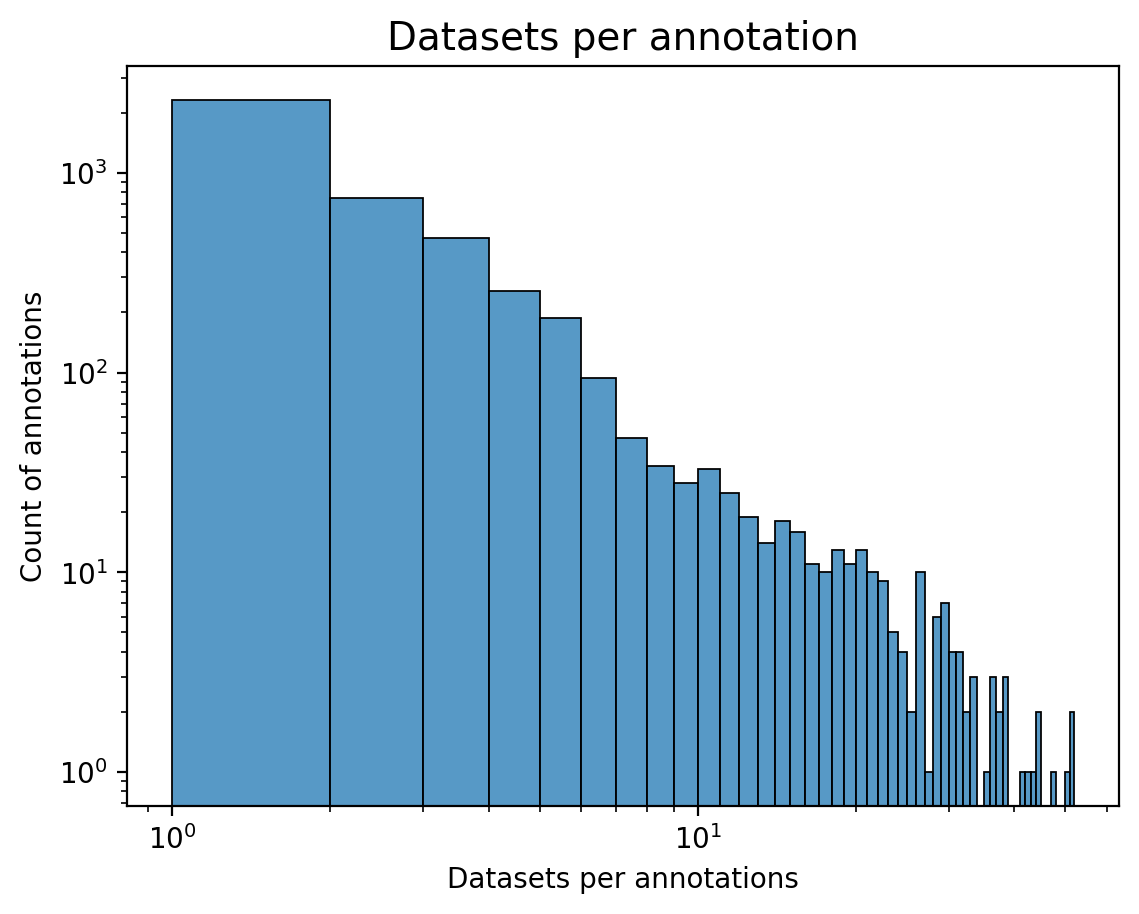

In [17]:
plt.figure(dpi=200)
vals = np.array(list(ind_freq.values()))
sn.histplot(vals, binwidth=1)
plt.xscale('log')
plt.yscale('log')
plt.title('Datasets per annotation', size=14)
plt.ylabel('Count of annotations')
plt.xlabel('Datasets per annotations')
plt.savefig('datasets_per_annotation.png', format = 'png')

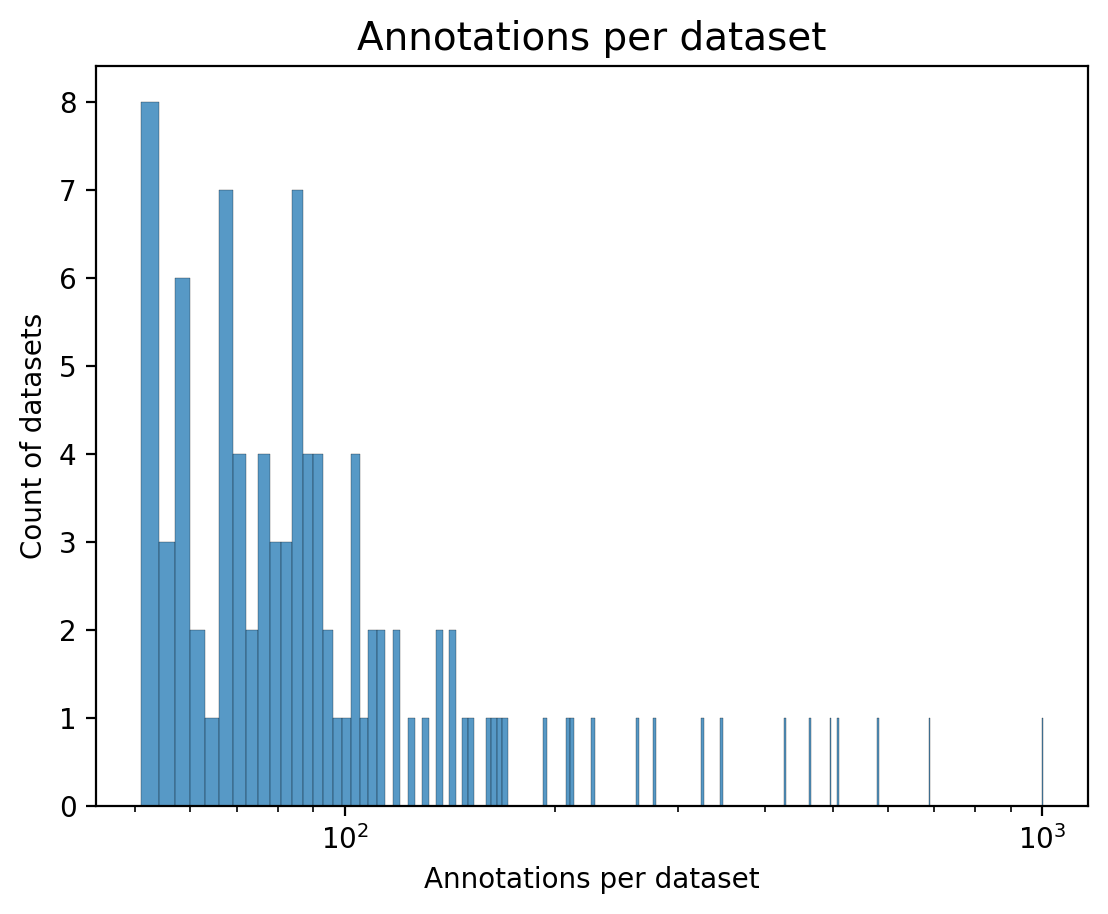

In [16]:
plt.figure(dpi=200)
vals = np.array(list(anno_freq.values()))
sn.histplot(vals, binwidth=3)
plt.xscale('log')
#plt.yscale('log')
plt.title('Annotations per dataset', size=14)
plt.ylabel('Count of datasets')
plt.xlabel('Annotations per dataset')

plt.savefig('annotations_per_dataset.png', format = 'png')

In [77]:
ion_arr = np.array(list(ind_freq.values()))
mask = ion_arr > 30

In [78]:
ion_arr[mask].shape

(27,)

In [9]:
def thresholding(ion_dict, thresh):
    ion_arr = np.array(list(ind_freq.values()))
    mask = ion_arr > thresh
    return ion_arr[mask]
    

In [10]:
thresholds = np.arange(0,50)
surviving_ions = [len(thresholding(ind_freq, t)) for t in thresholds]

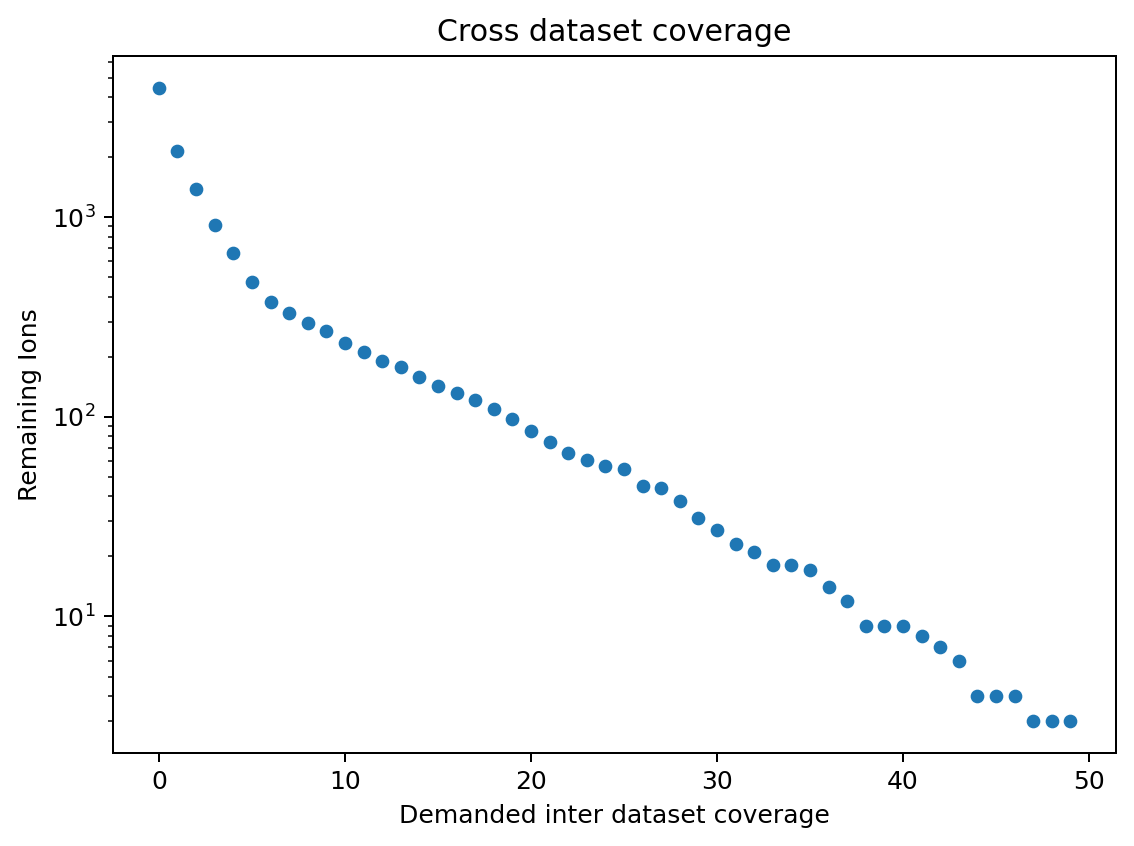

In [15]:
plt.figure(dpi=180)

plt.scatter(thresholds, surviving_ions, s=20)
plt.yscale('log')
plt.ylabel('Remaining Ions')
plt.xlabel('Demanded inter dataset coverage')
plt.title('Cross dataset coverage')

plt.tight_layout()

plt.savefig('cross-dataset-coverage.png', format='png')

In [99]:
#ions must occur in at least 5% of the datasets
surviving_ions[4]

659

In [106]:
dict_filtered = {k: v for k,v in ind_freq.items() if v > 4}

In [115]:
remaining_ions = list(dict_filtered.keys())
remaining_set = set(remaining_ions)

In [122]:
keep_list = []

for f in os.listdir(data_dir):
    if f.endswith('.pickle'):
        px_df = pd.read_pickle(os.path.join(data_dir,f))
        ions = px_df.drop(columns=['x', 'y']).columns.tolist()
        ions = set(ions)
        
        if remaining_set.intersection(ions):
            keep_list.append(f)

In [123]:
len(keep_list)

100

In [2]:
example_file = 'pixel_df_2022-09-15_11h13m32s.pickle'


In [4]:
DSID = '2022-09-15_11h13m32s'

fdr = 0.1
only_first_isotope = True
hotspot_clipping = False
norm = True

sm = SMInstance(host = METAHOST)
molset = sm.dataset(MOLDBNAME, DSID)

ann_df = molset.results(fdr=fdr) #annotation data frame
ann_ions = ann_df.ion.tolist() #list of ions and adduct
columns = ['y', 'x'] + ann_ions

images = molset.all_annotation_images(fdr= fdr, only_first_isotope=only_first_isotope, hotspot_clipping = hotspot_clipping)
images = filter_ions(images, ann_ions) # here, we make sure, that the ions of ann_df and images match

image_array = np.moveaxis((np.squeeze(np.array(images))), 0, -1) # move channel dimension to the last axis
pixel_no = np.shape(image_array[:,:,0].flatten())[0]

indices_array = np.moveaxis(np.indices((image_array.shape[0], image_array.shape[1])), 0, -1) # construct an index array
all_array = np.dstack((indices_array, image_array)).reshape((pixel_no,-1)) # merge index and image array,
                                                                           # reshaping to (index, (y,x,intensity))
pixel_df = pd.DataFrame(all_array, columns=columns).astype({'y': np.uint8, 'x': np.uint8})# create dataframe
if norm:
    pixel_df[ann_ions] = pixel_df[ann_ions] / (pixel_df[ann_ions].sum()) #normalize


100%|████████████████████████████████████████| 32/32 [00:00<00:00, 146.33it/s]


In [6]:
ann_df['moleculeNames']

formula     adduct
C5H13NO     +H                                                [Neurine]
C16H22O4    +K        [Alpha-CEHC, Diisobutyl phthalate, Monoethylhe...
            +H        [Alpha-CEHC, Diisobutyl phthalate, Monoethylhe...
            +Na       [Alpha-CEHC, Diisobutyl phthalate, Monoethylhe...
C14H24O4    +Na       [5-Nonyltetrahydro-2-oxo-3-furancarboxylic aci...
C19H18O3    +Na       [(E)-1-[4-Hydroxy-3-(3-methyl-1,3-butadienyl)p...
C14H26O4    +K        [Tetradecanedioic acid, Diethyl decanedioate, ...
            +H        [Tetradecanedioic acid, Diethyl decanedioate, ...
C17H22O3    +Na       [1b-Furanoeudesm-4(15)-en-1-ol acetate, [6]-De...
C7H15NO3    +H                          [L-Carnitine, Malonyl-Carnitin]
C14H26O4    +Na       [Tetradecanedioic acid, Diethyl decanedioate, ...
C13H24O4    +H        [1,11-Undecanedicarboxylic acid, Menthyl ethyl...
C12H12O3    +H        [Anofinic acid, 7-Ethoxy-4-methyl-2H-1-benzopy...
C5H9N3      +H                               

In [18]:
type(ann_df[ann_df['ion'] == 'C5H13NO+H+']['moleculeNames'].item())

list

In [23]:
ion_to_mols = { ion : ann_df[ann_df['ion'] == ion]['moleculeNames'].item()[0] for ion in ann_df['ion']  }

In [26]:
ion_to_mols

{'C5H13NO+H+': 'Neurine',
 'C16H22O4+K+': 'Alpha-CEHC',
 'C16H22O4+H+': 'Alpha-CEHC',
 'C16H22O4+Na+': 'Alpha-CEHC',
 'C14H24O4+Na+': '5-Nonyltetrahydro-2-oxo-3-furancarboxylic acid',
 'C19H18O3+Na+': '(E)-1-[4-Hydroxy-3-(3-methyl-1,3-butadienyl)phenyl]-2-(3,5-dihydroxyphenyl)ethylene',
 'C14H26O4+K+': 'Tetradecanedioic acid',
 'C14H26O4+H+': 'Tetradecanedioic acid',
 'C17H22O3+Na+': '1b-Furanoeudesm-4(15)-en-1-ol acetate',
 'C7H15NO3+H+': 'L-Carnitine',
 'C14H26O4+Na+': 'Tetradecanedioic acid',
 'C13H24O4+H+': '1,11-Undecanedicarboxylic acid',
 'C12H12O3+H+': 'Anofinic acid',
 'C5H9N3+H+': 'Histamine',
 'C22H40O4+Na+': 'Octadecyl fumarate',
 'C32H51NO12+Na+': '(3a,5b,7a,12a)-24-[(carboxymethyl)amino]-1,12-dihydroxy-24-oxocholan-3-yl-b-D-Glucopyranosiduronic acid',
 'C10H16O2+K+': 'Ascaridole',
 'C9H17NO4+H+': 'L-Acetylcarnitine',
 'C24H38O4+H+': '12-Ketodeoxycholic acid',
 'C10H16O2+H+': 'Ascaridole',
 'C10H14O+H+': '(-)-Pinocarvone',
 'C9H6O3+H+': '3 Hydroxycoumarin',
 'C8H18O3+H+': 

In [30]:

for ion in ann_df['ion']:
    if ion not in ion_to_mols:
        ion_to_mols[ion] = ann_df[ann_df['ion'] == ion]['moleculeNames'].item()[0]

In [31]:
ion_to_mols

{'C5H13NO+H+': 'Neurine',
 'C16H22O4+K+': 'Alpha-CEHC',
 'C16H22O4+H+': 'Alpha-CEHC',
 'C16H22O4+Na+': 'Alpha-CEHC',
 'C14H24O4+Na+': '5-Nonyltetrahydro-2-oxo-3-furancarboxylic acid',
 'C19H18O3+Na+': '(E)-1-[4-Hydroxy-3-(3-methyl-1,3-butadienyl)phenyl]-2-(3,5-dihydroxyphenyl)ethylene',
 'C14H26O4+K+': 'Tetradecanedioic acid',
 'C14H26O4+H+': 'Tetradecanedioic acid',
 'C17H22O3+Na+': '1b-Furanoeudesm-4(15)-en-1-ol acetate',
 'C7H15NO3+H+': 'L-Carnitine',
 'C14H26O4+Na+': 'Tetradecanedioic acid',
 'C13H24O4+H+': '1,11-Undecanedicarboxylic acid',
 'C12H12O3+H+': 'Anofinic acid',
 'C5H9N3+H+': 'Histamine',
 'C22H40O4+Na+': 'Octadecyl fumarate',
 'C32H51NO12+Na+': '(3a,5b,7a,12a)-24-[(carboxymethyl)amino]-1,12-dihydroxy-24-oxocholan-3-yl-b-D-Glucopyranosiduronic acid',
 'C10H16O2+K+': 'Ascaridole',
 'C9H17NO4+H+': 'L-Acetylcarnitine',
 'C24H38O4+H+': '12-Ketodeoxycholic acid',
 'C10H16O2+H+': 'Ascaridole',
 'C10H14O+H+': '(-)-Pinocarvone',
 'C9H6O3+H+': '3 Hydroxycoumarin',
 'C8H18O3+H+': 

In [36]:
pd.DataFrame.from_dict(ion_to_mols, orient='index').reset_index(level=0)

,index,0
0,C5H13NO+H+,Neurine
1,C16H22O4+K+,Alpha-CEHC
2,C16H22O4+H+,Alpha-CEHC
3,C16H22O4+Na+,Alpha-CEHC
4,C14H24O4+Na+,5-Nonyltetrahydro-2-oxo-3-furancarboxylic acid
5,C19H18O3+Na+,"(E)-1-[4-Hydroxy-3-(3-methyl-1,3-butadienyl)ph..."
6,C14H26O4+K+,Tetradecanedioic acid
7,C14H26O4+H+,Tetradecanedioic acid
8,C17H22O3+Na+,1b-Furanoeudesm-4(15)-en-1-ol acetate
9,C7H15NO3+H+,L-Carnitine


In [54]:
ion_mol_df = pd.DataFrame(data = [ion_to_mols.keys(), ion_to_mols.values()]).T.rename(columns = {0:'ions', 1:'moleculeNames'})


In [58]:
ion_mol_df.to_csv('Ions2Molecules.csv', index = False)

In [59]:
ANN_FILE = os.path.abspath("/scratch/trose/hmdbv4_300922/2021-12-21_01h14m46s.csv")



In [66]:
ann_df2 = pd.read_csv(ANN_FILE)
ann_df2

,formula,adduct,ionFormula,ion,mz,msm,rhoSpatial,rhoSpectral,moc,fdr,offSample,isotopeImages,colocCoeff,moleculeNames,moleculeIds,intensity
0,C30H18O8,+K,C30H18O8K,C30H18O8+K+,545.063247,0.451686,0.475844,0.952862,0.996190,0.05,True,"[{'mz': 545.0632473712369, 'url': 'https://s3....",NaN,['Protohypericin'],['HMDB0034180'],20143.742188
1,C18H26O17S,+K,C18H26O17SK,C18H26O17S+K+,585.052150,0.328922,0.344738,0.957933,0.996021,0.05,True,"[{'mz': 585.0521499372369, 'url': 'https://s3....",NaN,"['[(3,4,5-trihydroxy-6-{1,2,6-trihydroxy-3-[hy...","['HMDB0128277', 'HMDB0128278', 'HMDB0128279', ...",15711.632812
2,C18H14N2O6S,+Na,C18H14N2O6SNa,C18H14N2O6S+Na+,409.046400,0.300399,0.309129,0.976161,0.995491,0.05,True,"[{'mz': 409.04639951323674, 'url': 'https://s3...",NaN,['Lithol Rubine'],['HMDB0041567'],16506.921875
3,C40H78NO8P,+Na,C40H78NO8PNa,C40H78NO8P+Na+,754.535648,0.271779,0.306605,0.888026,0.998187,0.05,True,"[{'mz': 754.5356475512369, 'url': 'https://s3....",NaN,"['PC(14:0/18:1(11Z))', 'PC(14:0/18:1(9Z))', 'P...","['HMDB0007872', 'HMDB0007873', 'HMDB0007904', ...",20002.308594
4,C46H78O4,+K,C46H78O4K,C46H78O4+K+,733.553091,0.175472,0.192096,0.915628,0.997637,0.50,True,"[{'mz': 733.5530908112369, 'url': 'https://s3....",NaN,['3-Hexadecanoyloleanolic acid'],['HMDB0036967'],10712.085938
5,C10H17N7O9S,+K,C10H17N7O9SK,C10H17N7O9S+K+,450.043926,0.148873,0.154389,0.967343,0.996821,0.50,True,"[{'mz': 450.0439257592369, 'url': 'https://s3....",NaN,['Gonyautoxin I'],['HMDB0033506'],11749.506836


In [88]:
import ast
ion_to_mols = {}
for ion in ann_df2['ion']:
    if ion not in ion_to_mols:
        names = ast.literal_eval(ann_df2[ann_df2['ion'] == ion]['moleculeNames'].item())
        names.sort(key=len)
        short_name = names[0]
        ion_to_mols[ion] = ast.literal_eval(ann_df2[ann_df2['ion'] == ion]['moleculeNames'].item())[0]

In [79]:
ion_to_mols

{'C30H18O8+K+': 'Protohypericin',
 'C18H26O17S+K+': '[(3,4,5-trihydroxy-6-{1,2,6-trihydroxy-3-[hydroxy(3,4,5-trihydroxyoxan-2-yl)methyl]-4-oxocyclohexa-2,5-dien-1-yl}oxan-2-yl)methoxy]sulfonic acid',
 'C18H14N2O6S+Na+': 'Lithol Rubine',
 'C40H78NO8P+Na+': 'PC(14:0/18:1(11Z))',
 'C46H78O4+K+': '3-Hexadecanoyloleanolic acid',
 'C10H17N7O9S+K+': 'Gonyautoxin I'}